In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from copy import deepcopy
import pandas as pd
from rdkit import Geometry as Geom
from rdkit import RDLogger
import numpy as np
from sko.SA import SA
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.NeighborSearch import NeighborSearch
import random           # 20240511 寻优的时候加入随机初始值
RDLogger.DisableLog("rdApp.*")
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

global iaw, atoms_contact_cutoff, energy_scale
iaw = 0
atoms_contact_cutoff = 1
energy_scale = 1e6                                  #增加这个值，相当于将能量的贡献下降，这样分子内卷可能会小一点

In [2]:
def GenSmi3D(smi):
    mol = Chem.MolFromSmiles(smi)
    mol_h = Chem.AddHs(mol)
    # 生成初始3D构象
    AllChem.EmbedMolecule(mol_h)
    # 进行能量最小化优化
    AllChem.MMFFOptimizeMolecule(mol_h)

    return mol_h, Chem.RemoveHs(mol_h)

def MWInx(mol, counter):
    atoms = mol.GetNumAtoms()
    #_mol = deepcopy(mol)
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('idx',"{}-{}".format(counter,mol.GetAtomWithIdx(idx).GetIdx()))
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',"{}".format(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

def GNewIdx(frag, id, mark):
    for _atom in frag.GetAtoms():
        old_i = _atom.GetProp('idx')
        if old_i == "{}-{}".format(id, mark):
            return _atom.GetIdx()
    return None

def RLig(smi, id):
    lig,_ = GenSmi3D(smi)
    showlig = deepcopy(lig)
    # 3D -> 2D
    AllChem.Compute2DCoords(showlig)
    lig = MWInx(lig,id)
    showlig = MWInx(showlig,id)
    return lig,showlig

def CutLig(mol, g1):
    #g1 = (17,19)
    cut1 = mol.GetBondBetweenAtoms(*g1).GetIdx()
    cut_mol1 = Chem.FragmentOnBonds(mol,[cut1], addDummies=False)
    frags1 = Chem.GetMolFrags(cut_mol1,asMols=True)
    return frags1

def CutRep(mol, a1, gs):
    mol = deepcopy(mol)
    # 修改价态
    #oldcharge = mol.GetAtomWithIdx(a1).GetFormalCharge()
    #mol.GetAtomWithIdx(a1).SetFormalCharge(oldcharge-1)
    g_cut = []
    for g in gs:
        g_cut.append(mol.GetBondBetweenAtoms(*g).GetIdx())
    cut_mol2 = Chem.FragmentOnBonds(mol,g_cut, addDummies=False)
    frags2 = Chem.GetMolFrags(cut_mol2,asMols=True)
    return frags2

def RRep(fp,id):
    # 保留H，因此需要提前对残基补H
    mol = Chem.MolFromPDBFile(fp,removeHs=False)
    showmol = deepcopy(mol)
    # 3D -> 2D
    AllChem.Compute2DCoords(showmol)
    mol = MWInx(mol,id)
    showmol = MWInx(showmol,id)
    return mol, showmol

def CalTrans(a1,a2,mol1, mol2):
    # 计算平移量，相当于将O19平移至N
    O19Coor = mol1.GetConformer().GetAtomPosition(a1)
    H21Coor = mol2.GetConformer().GetAtomPosition(a2)
    translation_x = H21Coor.x - O19Coor.x
    translation_y = H21Coor.y - O19Coor.y
    translation_z = H21Coor.z - O19Coor.z
    return (translation_x,translation_y,translation_z)

def ComBMols(trans, mol1, mol2, id1, id2, ca1, ca2):
    mol1 = deepcopy(mol1)
    # 平移mol1
    mol1_conf = mol1.GetConformer()
    for i in range(mol1.GetNumAtoms()):
        mol1_conf.SetAtomPosition(i
                                      ,Geom.Point3D(mol1_conf.GetAtomPosition(i).x+trans[0]
                                                   ,mol1_conf.GetAtomPosition(i).y+trans[1]
                                                   ,mol1_conf.GetAtomPosition(i).z+trans[2]))
    
    Cmol = Chem.CombineMols(mol1,mol2)
    # 转化为可编辑
    ECmol_0 = Chem.EditableMol(Cmol)

    ECmol_0.AddBond(GNewIdx(Cmol, id1, ca1)
                             ,GNewIdx(Cmol, id2, ca2)
                             ,order=Chem.rdchem.BondType.SINGLE)
    
    final = ECmol_0.GetMol()

    #final.GetAtomWithIdx(GNewIdx(Cmol, id2, ca2)).SetFormalCharge(0)
    print(final.GetAtomWithIdx(GNewIdx(Cmol, id1, ca1)).GetFormalCharge())
    print(final.GetAtomWithIdx(GNewIdx(Cmol, id2, ca2)).GetFormalCharge())
    #final.GetAtomWithIdx(GNewIdx(Cmol, id1, ca1)).SetFormalCharge(0)
    return final

def MinMol(final,mol2, id2, a2,time=10):
    fix_atom = []
    a2_new_inx = GNewIdx(final, id2, a2)
    # 需要排除N上的H
    # 这样有bug，因为mol2已经删除了一个原子因此会造成索引的不连续
    old_fix_inx = [eval(mol2.GetAtomWithIdx(i).GetProp('idx').split("-")[-1]) for i in range(mol2.GetNumAtoms())]
    for i in old_fix_inx:
        # 固定部分原子
        atom_i = final.GetAtomWithIdx(GNewIdx(final, id2, i))
        if a2_new_inx not in [aa.GetIdx() for aa in atom_i.GetNeighbors()]:
            fix_atom.append(GNewIdx(final, id2, i))
    SIGN = 0
    counter = 0
    while counter < time:
        if not SIGN:
            # 创建一个分子对象
            mol = deepcopy(final)
            SIGN = 1
        # 创建一个力场对象
        # 20240510 2:19 加入UFF之后似乎可以优化键长或者键角
        energy = 0
        ff1 = AllChem.UFFGetMoleculeForceField(mol)
        ff2 = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol))

        if ff1:
            for i in fix_atom:
                ff1.AddFixedPoint(i) 
            ff1.Minimize()
            energy = ff1.CalcEnergy()

        if ff2:
            for i in fix_atom:
                ff2.AddFixedPoint(i) 
                # 进行分子的优化
            ff2.Minimize()
            energy = ff2.CalcEnergy()
            
        if not ff1 and not ff2:
            print("Please Check Mol, the ff is None!")
        # 添加额外的力场约束固定
    
        # 获取优化后的三维坐标
        conf = mol.GetConformer()
        # 能量
        #print(ff.CalcEnergy())
        counter += 1
    print("优化后的能量: ", energy)
    
    return mol

def GetFixAtom(final, mol2, id2):
    # final: 输入查询的分子
    # mol2: 固定部分的分子结构
    # id2: 固定部分分子的id
    fix_atom = []

    # 有bug，因为mol2已经删除了一个原子因此会造成索引的不连续
    old_fix_inx = [eval(mol2.GetAtomWithIdx(i).GetProp('idx').split("-")[-1]) for i in range(mol2.GetNumAtoms())]
    for i in old_fix_inx:
        # 固定部分原子
        fix_atom.append(GNewIdx(final, id2, i))
    # 返回的是在final上的索引
    return fix_atom

class MolRotBaseV0():
    def __init__(self, mol, atom_idxs, theta, sele_rot_atom_idx_final) -> None:
        self.mol = mol
        self.theta = theta
        self.atom_idxs = atom_idxs
        self.sele_rot_atom_idx_final = sele_rot_atom_idx_final
        self.v0, self.a2 = self.GetRotAxis()
        self.RotPos = self.GetRotAtomsPos()

    def GetRotAxis(self):
        # 获取旋转轴，规定旋转轴的方向是旋转部分指向固定部分
        # mol: 输入的分子
        # atom_idxs: 旋转轴定义原子，规定(fix, rot)
        rot_a1_idx, rot_a2_idx = self.atom_idxs
        # conformer
        conf = self.mol.GetConformer()
        rot_a1_pos_ = conf.GetAtomPosition(rot_a1_idx)
        rot_a2_pos_ = conf.GetAtomPosition(rot_a2_idx)

        rot_a1_pos = np.array([rot_a1_pos_.x, rot_a1_pos_.y, rot_a1_pos_.z])
        rot_a2_pos = np.array([rot_a2_pos_.x, rot_a2_pos_.y, rot_a2_pos_.z])
        v = (rot_a1_pos - rot_a2_pos) / np.linalg.norm((rot_a1_pos - rot_a2_pos))
        #/np.linalg.norm(rot_a2_pos)
        return v, rot_a2_pos

    def GetRotAtomsPos(self):
        conf = self.mol.GetConformer()
        poss = None
        for i,t in enumerate(self.sele_rot_atom_idx_final):
            pos_ = conf.GetAtomPosition(t)
            pos = np.array([pos_.x, pos_.y, pos_.z])
            if i == 0:
                poss = pos
            else:
                poss = np.vstack([poss, pos])
        return poss
  
    def __RotVBaseV0__(self,v):
        # theta: 需要旋转的角度，为弧度制
        # v: 待旋转的坐标向量
        # v0：旋转轴，方向向量
        x, y, z = self.v0
        a, b, c = self.a2
        cos = np.cos(self.theta)
        sin = np.sin(self.theta)
    
        R = np.array([ [x**2+(y**2+z**2)*cos, x*y*(1-cos)-z*sin   , x*z*(1-cos)+y*sin    , (a*(y**2+z**2)-x*(b*y+c*z))*(1-cos)+(b*z-c*y)*sin]
                      ,[x*y*(1-cos)+z*sin   , y**2+(x**2+z**2)*cos, y*z*(1-cos)-x*sin    , (b*(x**2+z**2)-y*(a*x+c*z))*(1-cos)+(c*x-a*z)*sin]
                      ,[x*z*(1-cos)-y*sin   , y*z*(1-cos)+x*sin   , z**2+(x**2+y**2)*cos , (c*(x**2+y**2)-z*(a*x+b*y))*(1-cos)+(a*y-b*x)*sin]
                      ,[                   0,                    0,                     0,                                                 1]])
        v = np.array([v[0], v[1], v[2], 1])

        out = np.dot(R, v)
        #print()
        return out[:-1]

    def RotAtoms(self):
        for i in range(self.RotPos.shape[0]):
            self.RotPos[i] = self.__RotVBaseV0__(self.RotPos[i])
        

    def SetRotAtomsPos(self):
        molout = deepcopy(self.mol)
        conf2 = molout.GetConformer()
        for i,t in enumerate(self.sele_rot_atom_idx_final):
            pos = self.RotPos[i]
            conf2.SetAtomPosition(t, pos)
        return molout

    def run(self):
        self.RotAtoms()
        outmol = self.SetRotAtomsPos()
        return outmol
    
def GetRotPartIdx(mol,fix_part,guideatom_id,sele_rot_bond_atoms):
    rot_a1, rot_a2 = sele_rot_bond_atoms
    cut1 = mol.GetBondBetweenAtoms(*sele_rot_bond_atoms).GetIdx()
    cut_mol1 = Chem.FragmentOnBonds(mol,[cut1], addDummies=False)
    frags1 = Chem.GetMolFrags(cut_mol1,asMols=True)
    select_part = None
    sele_rot_atom_idx = []
    sele_rot_atom_idx_final = []
    for frag in frags1:
        
        if not frag.HasSubstructMatch(fix_part) and guideatom_id not in [atom.GetProp('idx') for atom in frag.GetAtoms()]:
            # get rot_part 
            # 获取KLig_final上的索引
            select_part = frag
            #print([atom.GetProp('idx') for atom in frag.GetAtoms()], guideatom_id)
        #else:
        #    print(Chem.MolToSmiles(Chem.RemoveHs(frag)))

    for atom in select_part.GetAtoms():
        idx = atom.GetProp('idx')
        sele_rot_atom_idx.append(idx)

    for atom in mol.GetAtoms():
        if atom.GetProp('idx') in sele_rot_atom_idx:
            sele_rot_atom_idx_final.append(atom.GetIdx())

    fix_p_atom, rot_p_atom = None,None
    if sele_rot_bond_atoms[0] in sele_rot_atom_idx_final:
        rot_p_atom = sele_rot_bond_atoms[0]
        fix_p_atom = sele_rot_bond_atoms[1]
    else:
        rot_p_atom = sele_rot_bond_atoms[1]
        fix_p_atom = sele_rot_bond_atoms[0]

    return (fix_p_atom, rot_p_atom), sele_rot_atom_idx_final

def loadRepPDBOutAtom(fp, seleresnum):
    # 返回除自身外的所有原子
    # 20240511修订，去除自身残基
    p = PDBParser(PERMISSIVE=1)
    # 最后一行不能有END
    # pronoH2相比较于pronoH去掉ANISOU

    # 20240511 iaw: 正常来讲优化的残基应该不在这里面，但是从输出结果看，似乎
    #               盒子原子包含了
    s = p.get_structure("pro", fp)
    all_atom = []
    for res in s[0][' '].get_residues():
        if res.id[1] != seleresnum:
            #print(res.id)
            for atom in res.get_atoms():
                all_atom.append(atom)
        else:
            print("找到这个残基了",res.id[1])
    return all_atom

def GetRepBoxCoor(rep_atoms, ct, r):
    # 这一块需要修订，只要求非键相互作用 20230510
    out = NeighborSearch(rep_atoms, bucket_size=10).search(ct, r, level='A')
    box_coor = None
    for i, atom in enumerate(out):
        if i == 0:
            box_coor = atom.get_coord()
        else:
            _coor = atom.get_coord()
            box_coor = np.vstack((box_coor,_coor))
    return box_coor

class Floss():
    def __init__(self, mol,fixmol, guideatom_id, select_rotatable_bonds, box_coor):
        self.mol = mol
        self.fixmol = fixmol
        self.guideatom_id = guideatom_id
        self.select_rotatable_bonds = select_rotatable_bonds
        self.box_coor = box_coor                                        

    def __CalRotPartPoss2Box__(self,poss):

        # 储存最小接触
        all_min = []
        inside_min = []
        outside_min = []
        # 储存最小接触对应的原子，只检查outside
        optmol_poss_debug = []
        outside_poss_debug = []
        for i in range(poss.shape[0]):
            i_coor = poss[i]
            other_coor = poss[i+1:]
            # 20240510修订
            i_dist1 = np.power(np.power(self.box_coor - i_coor,2).sum(axis=1),0.5)
            # 索引
            i_dist1_min_idx = np.argmin(i_dist1)
            # 距离
            i_dist1_min = i_dist1[i_dist1_min_idx]
            # 坐标
            i_outside_coor = self.box_coor[i_dist1_min_idx]
            # 储存
            all_min.append(i_dist1_min)
            outside_min.append(i_dist1_min)
            outside_poss_debug.append(i_outside_coor)
            optmol_poss_debug.append(i_coor)
           
            # 计算分子自身的最小接触原子，这里需要排除键
            if i != poss.shape[0]-1:
                i_dist2 = np.power(np.power(other_coor - i_coor,2).sum(axis=1),0.5)
                i_dist2_min_idx = np.argmin(i_dist2)
                i_dist2_min = i_dist2[i_dist2_min_idx]
                all_min.append(i_dist2_min)
                inside_min.append(i_dist2_min)
        
        all_min_idx = np.argmin(np.array(all_min))
        all_outside_min_idx = np.argmin(np.array(outside_min))
        if iaw % 1000 == 0:
            print("IAW: Min outside={:.6f}, ToTal: {:.4f}/{}, Min inside={:.6f}, Total: {:.4f}/{}, {:.4f}/{}\nOutside coor:\n{}->{}".format(min(outside_min)
                                        , sum(outside_min)
                                        , len(outside_min)
                                        , min(inside_min)
                                        , sum(inside_min)
                                        , len(inside_min)
                                        , sum(all_min)
                                        , len(all_min)
                                        , outside_poss_debug[all_outside_min_idx]
                                        , optmol_poss_debug[all_outside_min_idx]))
        # 设置截断值，也就是所有距离小于1的不良接触均会被考虑
        # 传递每个原子跟周围残基的最小接触
        return -sum(all_min)
        #return all_min[all_min_idx]
        #return np.array(all_min)[np.where(np.array(all_min) < atoms_contact_cutoff)].sum()
    
    def GetOptCoor(self, mol):
        # 获取优化部分的原子坐标
        # 先获取固定部分的索引
        fix_idx = []
        conf = mol.GetConformer()
        poss = "str"
        
        for atom in self.fixmol.GetAtoms():
            # 唯一标识符
            idx = atom.GetProp('idx')
            fix_idx.append(idx)
        for atom in mol.GetAtoms():
            idx = atom.GetProp('idx')
            if idx not in fix_idx:
                # 获取坐标
                new_idx = atom.GetIdx()
                pos_ = conf.GetAtomPosition(new_idx)
                pos = np.array([pos_.x, pos_.y, pos_.z])
                if type(poss) == str:
                     poss = pos
                else:
                    poss = np.vstack([poss, pos])
        return poss
    
    def run(self, angs):
        usemol = deepcopy(self.mol)
        poss = None
        for i,a in enumerate(angs):
            atom_idxs, sele_rot_atom_idx_final = GetRotPartIdx(usemol, self.fixmol,self.guideatom_id,self.select_rotatable_bonds[i])
            # print(sele_rot_atom_idx_final)
            myrot = MolRotBaseV0(mol=usemol, atom_idxs=atom_idxs, theta=a*np.pi, sele_rot_atom_idx_final=sele_rot_atom_idx_final)
            # 更新分子构象
            usemol = myrot.run()
            # 记录一下最后一个键旋转之后旋转部分的坐标
            if i == len(angs) -1:
                poss = self.GetOptCoor(usemol)
        
        # 计算距离
        dist = self.__CalRotPartPoss2Box__(poss)
        # 计算能量
        en = None
        enSign = None
        ff1 = AllChem.UFFGetMoleculeForceField(usemol)
        ff2 = AllChem.MMFFGetMoleculeForceField(usemol, AllChem.MMFFGetMoleculeProperties(usemol))
        if ff1:
            en = ff1.CalcEnergy()
            enSign = "UFF"

        if ff2:
            en = ff2.CalcEnergy()
            enSign == "MMFF"
            
        if not ff1 and not ff2:
            print("Please Check Mol, the ff is None!")
            enSign = "Error"
            en = 1000000000000
        
        global iaw
        if iaw%1000 == 0:
            print("Atomic minimum contact: {:.8f}, Energy[{}]: {:.4f}".format(dist, enSign,en))
            # 能量缩小10000倍
            #Chem.MolToPDBFile(usemol, "./debug/SA-Min-{}.pdb".format(iaw))
        iaw += 1

        return dist+en/energy_scale
    
def GetAIdxCoor(mol, idx):
    conf = mol.GetConformer()
    pos = conf.GetAtomPosition(idx)
    return [pos.x, pos.y, pos.z]

class ApplyParm():
    def __init__(self, mol,fixmol,guideatom_id, select_rotatable_bonds, box_coor):
        self.mol = mol
        self.fixmol = fixmol
        self.guideatom_id = guideatom_id
        self.select_rotatable_bonds = select_rotatable_bonds
        self.box_coor = box_coor           
    def __CalRotPartPoss2Box__(self,poss):
        #dist = 0.0
        dist = []
        for i in range(poss.shape[0]):
            i_coor = poss[i]
            other_coor = poss[i+1:]
            # 20240510修订
            # 计算自身：
            # 找到距离最小的，也就是让距离最小的原子距离求最大
            i_dist1 = np.power(self.box_coor - i_coor,2).min()
            #print("周围原子 -> 修饰位点原子 <= 1: \n{}\n\t||\n\t{}".format(self.box_coor[np.where(i_dist1<=1)]
            #                                                            , i_coor))
            dist.append(i_dist1)
            
            # 这里需要更新，因为H键是小于1埃米的
            if i != poss.shape[0]-1:
                i_dist2 = np.power(other_coor - i_coor,2).min()
                #print("修饰位点原子内部原子距离 <= 1: \n{}\n\t||\n\t{}".format(self.box_coor[np.where(i_dist1<=1)]
                #                                                            ,i_coor))
                dist.append(i_dist2)
            #i_dist = -np.power(self.box_coor - i_coor,2).sum()/self.box_coor.shape[0]
            #dist += i_dist
        # 20240510修订，计算平均值
        #return dist/poss.shape[0]
        
        return -min(dist)

    def GetOptCoor(self):
        # 获取优化部分的原子坐标
        # 先获取固定部分的索引
        self.mol
        fix_idx = []
        conf = self.mol.GetConformer()
        poss = "str"
        for atom in self.fixmol.GetAtoms():
            # 唯一标识符
            idx = atom.GetProp('idx')
            fix_idx.append(idx)
        for atom in self.mol.GetAtoms():
            idx = atom.GetProp('idx')
            if idx not in fix_idx:
                # 获取坐标
                new_idx = atom.GetIdx()
                pos_ = conf.GetAtomPosition(new_idx)
                pos = np.array([pos_.x, pos_.y, pos_.z])
                if type(poss) == str:
                     poss = pos
                else:
                    poss = np.vstack([poss, pos])
        return poss

    def run(self, angs):
        usemol = deepcopy(self.mol)
        poss = None
        for i,a in enumerate(angs):
            atom_idxs, sele_rot_atom_idx_final = GetRotPartIdx(usemol, self.fixmol,self.guideatom_id, self.select_rotatable_bonds[i])
            myrot = MolRotBaseV0(mol=usemol, atom_idxs=atom_idxs,theta=a*np.pi,sele_rot_atom_idx_final=sele_rot_atom_idx_final)
            # 更新分子构象
            usemol = myrot.run()
            if i == len(angs) -1:
                poss = self.GetOptCoor()

        #dist = self.__CalRotPartPoss2Box__(poss)
        #print("最终最小接触距离：{:.4f}".format(dist))
        return usemol

In [ ]:
15E-SP : bond_w 2.12+1.  unbond:1.20±0.51
15E-MC : bond_w 2.13+1.0 unbond:1.19+0.51


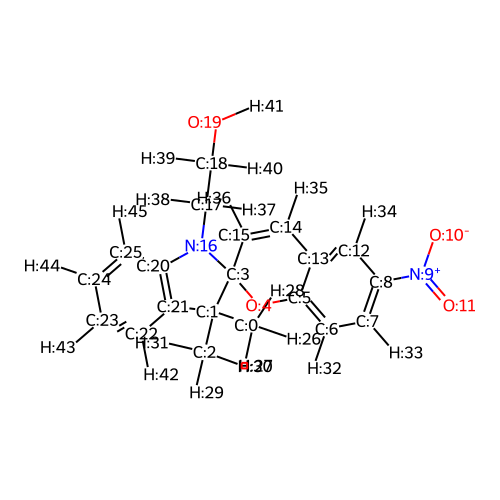

In [3]:
smi = "CC1(C)C2(OC(C=CC([N+]([O-])=O)=C3)=C3C=C2)N(CCO)C4=C1C=CC=C4"
lig, showlig = RLig(smi, 0)
Draw.MolToImage(showlig,size=(500,500))

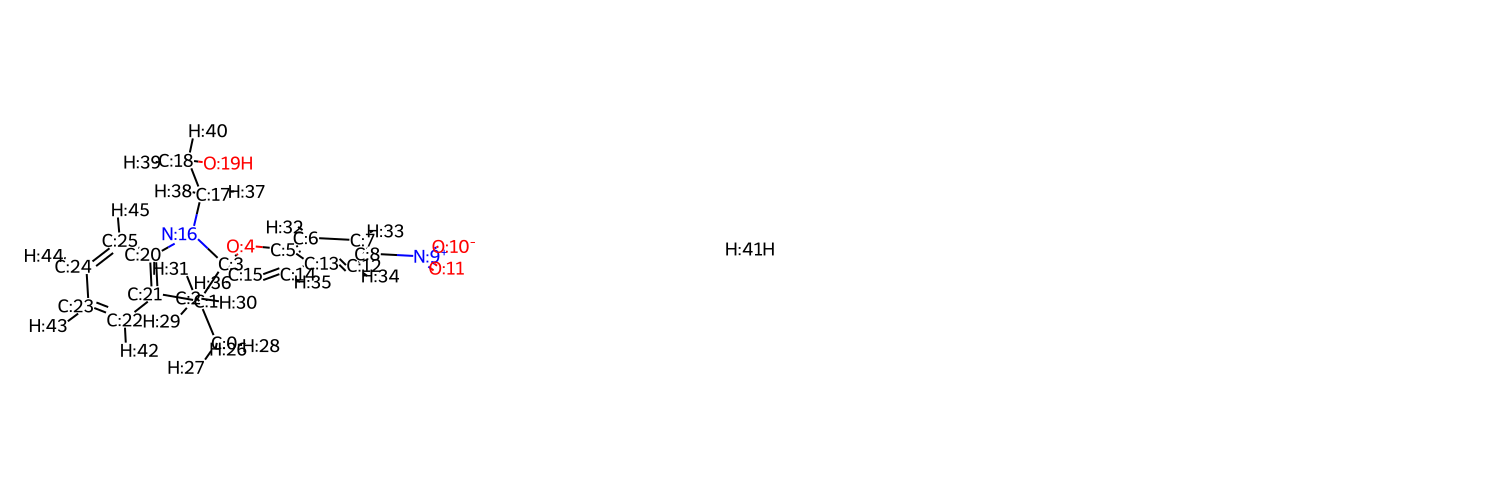

In [5]:
# 切割
lig_fix_atom = 19
lig_rm_atom = 41
ligfrag = CutLig(lig, (lig_fix_atom,lig_rm_atom))
Draw.MolsToGridImage(ligfrag,subImgSize=(500,500)) 

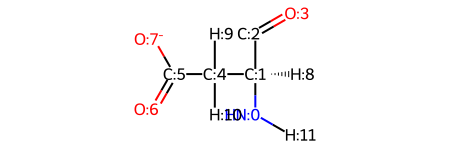

In [6]:
counter = 2
fp = "ASP35"
resnum = 35 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

### ASP35

In [17]:
counter = 2
fp = "ASP35"
resnum = 35 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4bb270>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4bb7b0>
优化后的能量:  81.00332858248866
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 35
IAW: Min outside=2.959440, ToTal: 247.7823/45, Min inside=1.080562, Total: 78.2866/44, 326.0689/89
Outside coor:
[64.33  37.011  2.32 ]->[63.50668653 39.18640241  0.49022641]
Atomic minimum contact: -326.06888610, Energy[UFF]: 311.2510
IAW: Min outside=0.562720, ToTal: 222.4836/45, Min inside=1.080562, Total: 79.8899/44, 302.3735/89
Outside coor:
[67.57  37.574  3.246]->[67.43352024 38.09278319  3.07602362]
Atomic minimum contact: -302.37350134, Energy[UFF]: 104.6561
IAW: Min outside=0.896740, ToTal: 155.7233/45, Min inside=1.080562, Total: 77.4962/44, 233.2195/89
Outside coor:
[68.751 40.868  7.07 ]-

### ASP39

In [18]:
counter = 3
fp = "ASP39"
resnum = 39 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4b0350>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b9900>
优化后的能量:  79.76714851945577
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 39
IAW: Min outside=0.261597, ToTal: 68.5361/45, Min inside=1.080674, Total: 80.8687/44, 149.4049/89
Outside coor:
[76.834 35.593  8.509]->[76.87059342 35.55328879  8.25303649]
Atomic minimum contact: -149.40486128, Energy[UFF]: 6153042189.6552
IAW: Min outside=0.671362, ToTal: 105.9635/45, Min inside=1.080674, Total: 78.6683/44, 184.6318/89
Outside coor:
[74.114 44.67   9.537]->[74.27179869 44.24239358 10.0299299 ]
Atomic minimum contact: -184.63177251, Energy[UFF]: 62840052.0349
IAW: Min outside=1.742473, ToTal: 244.2869/45, Min inside=1.080674, Total: 78.4633/44, 322.7503/89
Outside coor:
[79.674 46.2

### ASP239

In [19]:
counter = 4
fp = "ASP239"
resnum = 239 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a20db30>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4b0510>
优化后的能量:  85.84844577006423
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 239
IAW: Min outside=0.385040, ToTal: 151.7378/45, Min inside=0.128286, Total: 78.9105/44, 230.6482/89
Outside coor:
[64.13  65.546 44.946]->[64.21830188 65.72033447 45.27775898]
Atomic minimum contact: -230.64822668, Energy[UFF]: 137.8712
IAW: Min outside=0.784235, ToTal: 115.3677/45, Min inside=0.128286, Total: 79.5203/44, 194.8880/89
Outside coor:
[72.15  69.592 38.826]->[71.71654151 69.48224181 39.47027462]
Atomic minimum contact: -194.88800346, Energy[UFF]: 1031922.5968
IAW: Min outside=0.464987, ToTal: 144.6432/45, Min inside=0.128286, Total: 75.2867/44, 219.9298/89
Outside coor:
[73.46  65.689 45.

### ASP394

In [23]:
counter = 5
fp = "ASP394"
resnum = 394 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-3
            , L=100
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7f84b5342ac0>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7f84b53683c0>
优化后的能量:  72.05771777371258
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 394
IAW: Min outside=0.405595, ToTal: 109.3420/45, Min inside=1.083513, Total: 78.0345/44, 187.3765/89
Outside coor:
[38.679 38.94  34.079]->[38.39296062 38.85640302 33.80386226]
Atomic minimum contact: -187.37653272, Energy[UFF]: 221.4883
IAW: Min outside=0.514739, ToTal: 144.3588/45, Min inside=1.083513, Total: 78.3285/44, 222.6874/89
Outside coor:
[40.006 37.918 31.831]->[39.92699793 38.34918855 32.10079761]
Atomic minimum contact: -222.68736153, Energy[UFF]: 198.7302
Angle[0]:                                   1.716714pi
Angle[1]:                                   1.969244pi
Angle[2]:                

### ASP437

In [21]:
counter = 6
fp = "ASP437"
resnum = 437 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41c065040>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b9890>
优化后的能量:  82.40476839194415
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 437
IAW: Min outside=0.538918, ToTal: 62.2266/45, Min inside=1.080948, Total: 78.9849/44, 141.2115/89
Outside coor:
[78.399 33.444 15.412]->[78.2143783  33.49016552 15.91619801]
Atomic minimum contact: -141.21150592, Energy[UFF]: 545.9346
IAW: Min outside=0.268627, ToTal: 72.7676/45, Min inside=1.080948, Total: 76.8248/44, 149.5924/89
Outside coor:
[81.434 32.467 19.769]->[81.68918465 32.54192093 19.80677244]
Atomic minimum contact: -149.59237180, Energy[UFF]: 299.1942
IAW: Min outside=0.355936, ToTal: 67.2894/45, Min inside=1.080948, Total: 78.5090/44, 145.7984/89
Outside coor:
[79.365 32.115 19.435]->[

### ASP535

In [22]:
counter = 7
fp = "ASP535"
resnum = 535 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b99e0>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b9890>
优化后的能量:  80.06041184963547
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 535
IAW: Min outside=0.923854, ToTal: 169.4456/45, Min inside=1.080580, Total: 79.9881/44, 249.4337/89
Outside coor:
[69.38  27.458  4.446]->[70.11947284 27.29730982  4.97596372]
Atomic minimum contact: -249.43371429, Energy[UFF]: 543632.9200
IAW: Min outside=0.294259, ToTal: 126.2696/45, Min inside=1.080580, Total: 77.5788/44, 203.8484/89
Outside coor:
[74.273 20.914  2.203]->[74.46151277 20.82116157  2.40899398]
Atomic minimum contact: -203.84840435, Energy[UFF]: 1188.2343
IAW: Min outside=0.370081, ToTal: 189.7929/45, Min inside=1.080580, Total: 80.2300/44, 270.0229/89
Outside coor:
[71.914 26.662 -1.

### ASP539

In [23]:
counter = 8
fp = "ASP539"
resnum = 539 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4b0510>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b9890>
优化后的能量:  87.36708207588671
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 539
IAW: Min outside=0.275230, ToTal: 134.3116/45, Min inside=1.080549, Total: 79.1079/44, 213.4195/89
Outside coor:
[63.019 27.333 -1.765]->[63.18336192 27.5020242  -1.62298612]
Atomic minimum contact: -213.41949991, Energy[UFF]: 91.7037
IAW: Min outside=0.342485, ToTal: 98.8420/45, Min inside=1.080549, Total: 80.9470/44, 179.7890/89
Outside coor:
[63.079 30.741  3.743]->[62.95996185 30.9434233   3.49369928]
Atomic minimum contact: -179.78903421, Energy[UFF]: 167573.7796
IAW: Min outside=0.364156, ToTal: 56.0275/45, Min inside=1.080549, Total: 78.5121/44, 134.5395/89
Outside coor:
[66.432 31.476  4.891]

### ASP739

In [24]:
counter = 9
fp = "ASP739"
resnum = 739 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a4b02e0>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fe41a1b9890>
优化后的能量:  89.78750435675255
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 739
IAW: Min outside=0.536575, ToTal: 162.8141/45, Min inside=1.080907, Total: 78.1679/44, 240.9820/89
Outside coor:
[58.98  -6.574 16.496]->[59.32861017 -6.17312991 16.57140812]
Atomic minimum contact: -240.98201574, Energy[UFF]: 1511.8979
IAW: Min outside=0.536575, ToTal: 139.1211/45, Min inside=1.080907, Total: 79.8012/44, 218.9223/89
Outside coor:
[58.98  -6.574 16.496]->[59.32861017 -6.17312991 16.57140812]
Atomic minimum contact: -218.92227339, Energy[UFF]: 3402757213.7327
IAW: Min outside=0.285354, ToTal: 64.3412/45, Min inside=1.080907, Total: 78.7014/44, 143.0426/89
Outside coor:
[61.351  1.781 

### ASP894

In [5]:
counter = 10
fp = "ASP894"
resnum = 894 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-6
            , L=500
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7f13bad9e510>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7f13bad9ec10>
优化后的能量:  76.5599850575232
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 894
IAW: Min outside=0.375841, ToTal: 83.0061/45, Min inside=0.127398, Total: 78.6850/44, 161.6911/89
Outside coor:
[85.112 23.58  33.159]->[85.46914211 23.65150117 33.25170162]
Atomic minimum contact: -161.69114222, Energy[UFF]: 728.1732
IAW: Min outside=0.269516, ToTal: 55.8743/45, Min inside=0.127398, Total: 77.4595/44, 133.3337/89
Outside coor:
[82.849 23.833 34.206]->[82.68080201 23.69836797 34.36793609]
Atomic minimum contact: -133.33374030, Energy[UFF]: 108.0708
IAW: Min outside=0.117066, ToTal: 61.5332/45, Min inside=0.127398, Total: 77.9268/44, 139.4600/89
Outside coor:
[79.212 23.43  32.868]->[7

### ASP937

In [7]:
counter = 11
fp = "ASP937"
resnum = 937 # 必须数字
# 读取配体
rep,showrep = RRep("../res/{}.pdb".format(fp),counter)
showrep

rep_fix_atom = 5
rep_guide_atom = 4
rep_rm_atom = 7
rep_rm_atom_ = None

fp_pro = "../wH.pdb"
outfp = "./out/{}".format(fp)
r_neighbor = 25

# 切割
Repfrag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_rm_atom)])
# 计算偏移量
trans_fp =  CalTrans(lig_fix_atom,rep_rm_atom, lig, rep)
# 拼接
KLig = ComBMols(trans=trans_fp,mol1=ligfrag[0], mol2=Repfrag[0], id1=0, id2=counter, ca1=lig_fix_atom, ca2=rep_fix_atom)
# 保存拼接后的分子
Chem.MolToPDBFile(KLig, "{}-ComB.pdb".format(outfp))

# 很神奇，只要这写了这个就可以正常？？？？
ff = AllChem.MMFFGetMoleculeForceField(KLig, AllChem.MMFFGetMoleculeProperties(KLig))
print("MMFF avail: ", ff)
ff = AllChem.UFFGetMoleculeForceField(KLig)
print("UFF avail: ", ff)


# 优化
## 20240510 1:20修订，把guild之前的部分完全放开,相当于一个新的片段，即fix-guide之间断开
if rep_guide_atom != -1:
    Rep2frag = CutRep(rep, rep_fix_atom,[(rep_fix_atom,rep_guide_atom)])
    KLig_final = MinMol(KLig, Rep2frag[0], id2=counter, a2=rep_fix_atom,time=1000)
else:
    print("未找到guide原子，不优化：rep_fix---rep")
    KLig_final = MinMol(KLig, Repfrag[0], id2=counter, a2=rep_fix_atom,time=1000)

# 保存优化后的分子
Chem.MolToPDBFile(KLig_final, "{}-min.pdb".format(outfp))

# 从优化后的分子中获取固定部分原子索引
fix_atom = GetFixAtom(KLig_final, Repfrag[0], id2=counter)
#print(fix_atom)

# 获取旋转键
# 单键、非环、非氢键
rotatable_bonds = Chem.Mol.GetSubstructMatches(KLig_final, Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]'))
print("原始可旋转键：", rotatable_bonds)

id2=counter
a2=rep_fix_atom
# 排除固定原子上的非标准氨基酸
select_rotatable_bonds1 = []
select_rotatable_bonds2 = []
a2_new_inx = GNewIdx(KLig_final, id2, a2)
for bond in rotatable_bonds:
    if not (set(bond) & set(fix_atom)):
        # 只选取不包含固定原子的可旋转键    
        select_rotatable_bonds1.append(bond)
    elif a2_new_inx in set(bond) and  GNewIdx(KLig_final, 0, lig_fix_atom) in set(bond):
        # 如果存在guide原子，则让rep_fix_atom-rep_guide_atom可以旋转
        select_rotatable_bonds1.append(bond)
# 排除H键
for bond in select_rotatable_bonds1:
    if KLig_final.GetAtomWithIdx(bond[0]).GetSymbol() != "H" and KLig_final.GetAtomWithIdx(bond[1]).GetSymbol() != "H":
        select_rotatable_bonds2.append(bond)
print("实际选择的可旋转键：", select_rotatable_bonds2)

mol = deepcopy(KLig_final)
select_rotatable_bonds = select_rotatable_bonds2

# 加载受体的非对接残基
rep_atoms = loadRepPDBOutAtom(fp=fp_pro,seleresnum=resnum)
# 获取目前rep_fix_atom的坐标
a2_new_inx_coor = GetAIdxCoor(mol=KLig_final, idx=a2_new_inx)
# 在蛋白上获取以rep_fix_atom为圆心r_neighbor为半径范围内的原子
box_coor = GetRepBoxCoor(rep_atoms=rep_atoms,ct=a2_new_inx_coor,r=r_neighbor)

NumRotAng = len(select_rotatable_bonds)
coorSA = SA(func=Floss(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) ,select_rotatable_bonds, box_coor).run
            , x0=[random.uniform(0, 2) for i in range(NumRotAng)]
            , T_max=1
            , T_min=1e-5
            , L=100
            , max_stay_counter=100
            , lb=[0 for i in range(NumRotAng)]
            , ub=[2 for i in range(NumRotAng)])
# 模拟退火优化
_x, _y = coorSA.run()
# 输出优化结果
for i,ang in enumerate(_x):
    print("Angle[{}]:{:43f}pi".format(i,ang))
final = ApplyParm(mol, Repfrag[0], "{}-{}".format(counter, rep_guide_atom) , select_rotatable_bonds, box_coor).run(_x)
# 保留结果
Chem.MolToPDBFile(final, "{}_final.pdb".format(outfp))


0
0
MMFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fbbba8aba50>
UFF avail:  <rdkit.ForceField.rdForceField.ForceField object at 0x7fbbb8ec9f90>
优化后的能量:  65.20298208776973
原始可旋转键： ((0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50), (45, 46), (46, 47), (46, 49), (49, 50))
实际选择的可旋转键： [(0, 1), (1, 2), (8, 9), (16, 17), (17, 18), (18, 19), (19, 50)]
找到这个残基了 937
IAW: Min outside=0.279415, ToTal: 54.6475/45, Min inside=1.083672, Total: 80.2023/44, 134.8498/89
Outside coor:
[55.056 33.686 20.956]->[54.86466602 33.69384401 21.15947558]
Atomic minimum contact: -134.84975552, Energy[UFF]: 755.5989
IAW: Min outside=0.549574, ToTal: 51.1900/45, Min inside=1.083672, Total: 77.9937/44, 129.1838/89
Outside coor:
[51.921 36.149 16.098]->[51.73342523 36.45420691 15.68123254]
Atomic minimum contact: -129.18377946, Energy[UFF]: 318.7050
IAW: Min outside=0.163057, ToTal: 63.0454/45, Min inside=1.083672, Total: 77.2105/44, 140.2559/89
Outside coor:
[47.364 34.886 11.61 ]->[